In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import nibabel as nib
from nibabel.testing import data_path 

import skimage
from skimage import measure

import scipy
import scipy.ndimage as morphology
# import plotly.express as px

import pandas as pd 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition, datasets

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import warnings
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import RobustScaler , MinMaxScaler
from torch.utils.data import Dataset




from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from tqdm import tqdm
import cv2

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
def evaluate(vae: nn.Module, dataloader:DataLoader):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(dataloader):
            recon_batch, mu, log_var = vae(batch_data)
            total_loss += loss_function(recon_batch, batch_data, mu, log_var).item()
    avg_loss = total_loss / len(dataloader.dataset)
    print('Validation Loss: {:.4f}'.format(avg_loss))


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (input_dim // 8) * (input_dim // 8), latent_dim * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (input_dim // 8) * (input_dim // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (64, input_dim // 8, input_dim // 8)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 5)
        )
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(mu.device)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var
    
    def forward_mlp(self, mu):
        edmu, esmu = torch.chunk(mu, chunks=2, dim=0)
        pred = torch.cat([edmu, esmu], dim=1)
        return self.mlp(pred)
    
    def bottle_neck(self, x):
        mu, log_var = self.encode(x)
        return mu
        

In [14]:
def get_classification_data(path, classes, features, input_size=(224,224,1)):
    img_ED = []
    img_ES = []
    y = []
    manual_features = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if ".gz" and "frame" in file:
                if "_sg" in file:
                    img_path = root + "/" + file
                    nifti_file = nib.load(img_path)
                    nifti_img = nifti_file.get_fdata()
                    patient_id = int(file.split("_")[0][-3:])
                    # print("patient_id ", patient_id)
                    patient_class = classes.loc[patient_id]["Category"]
#                     if ("01" in file[-9:]) or ("04" in file[-9:]):
                    if ("01" in file[-12:]) or ("04" in file[-12:]):
                        img_ED.append(nifti_img)
                        y.append(patient_class)
                        manual_features.append(features.loc[patient_id])
                    else:
                        img_ES.append(nifti_img)
    return img_ED, img_ES, manual_features, y

def preprocess(x):
    return (torch.nn.functional.interpolate(torch.from_numpy(x)[None,None, ...], (224, 224))[0].to(int)).to(torch.float32) / 3.

def extract_frames(ED, ES, y, manual, input_size=(224, 224)):
    ED_extracted = []
    ES_extracted = []
    y_extracted = []
    f_extracted = []
    for file_patient in range(y.shape[0]):
        nifti_img_ED = ED[file_patient]
        nifti_img_ES = ES[file_patient]

        for idx in range(nifti_img_ED.shape[2]):
                i = preprocess(nifti_img_ED[:,:,idx]).numpy()[0]
                j = preprocess(nifti_img_ES[:,:,idx]).numpy()[0]

                patient_class = y[file_patient]
                ED_extracted.append(i)
                ES_extracted.append(j)
                y_extracted.append(patient_class)
                f_extracted.append(manual[file_patient])               
    return np.array(ED_extracted), np.array(ES_extracted), np.array(f_extracted), np.array(y_extracted)

def extract_frames_test(ED, ES, y, manual, input_size=(224, 224)):
    ED_extracted = []
    ES_extracted = []
    y_extracted = []
    f_extracted = []
    
    for idx in range(ED.shape[2]):
        i = preprocess(ED[:,:,idx]).numpy()[0]
        j = preprocess(ES[:,:,idx]).numpy()[0]
         
        ED_extracted.append(i)
        ES_extracted.append(j)
        y_extracted.append(y)
        f_extracted.append(manual)
        
    return np.array(ED_extracted), np.array(ES_extracted), np.array(f_extracted), np.array(y_extracted)

In [15]:
def most_frequent(nums):
    return max(set(nums), key=nums.count)


def report(model, is_concat=True, verbose=True):
    true_labels_all = []
    predictions_all = []

    for i in range(len(img_ED_test)):

        img_ED, img_ES, y, f_test = img_ED_test[i], img_ES_test[i], y_test[i], manual_features_test[i]

        img_ED, img_ES, f_test, y = extract_frames_test(img_ED, img_ES, y, f_test)
        ED_ES = np.stack([img_ED, img_ES], axis=1)
        f_test = scaler.transform(f_test)


        
        true_labels = []
        predictions = []

        # No gradient needed for evaluation
        vae.eval()
        with torch.no_grad():
            f = vae.bottle_neck(torch.from_numpy(ED_ES.reshape(ED_ES.shape[0]*2, 1, 224, 224)))
            f = f.reshape(ED_ES.shape[0], 2 * 16).numpy()
            
            if is_concat:
                f = np.concatenate([f, f_test], axis=1)
                
#         res = pipeline(ED_ES, f_test)
#         print("res.shape",res.shape)
        preds = model.predict(f)

        predictions.extend(preds)  
        true_labels.extend(y)
        pred_class = most_frequent(predictions)
        true_class = most_frequent(true_labels)

        true_labels_all.append(true_class)
        predictions_all.append(pred_class)

    if verbose:
        print("predictions:", predictions_all)
        print("true_labels:", true_labels_all)

        precision = precision_score(true_labels_all, predictions_all, average='macro')  # You can change average mode
        recall = recall_score(true_labels_all, predictions_all, average='macro')
        f1 = f1_score(true_labels_all, predictions_all, average='macro')

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
    accuracy = accuracy_score(true_labels_all, predictions_all)
    print(f"Accuracy: {accuracy}")
    conf_matrix = confusion_matrix(true_labels_all, predictions_all)
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(true_labels_all,predictions_all))
    return true_labels_all, predictions_all

    


In [16]:
# input_dim = 224
# latent_dim = 16
# resume = "358-401"
# start_epoch = 0
# end_epoch = 0
# vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
# if resume is not None:
#     start_epoch = int(resume.split("-")[0])
#     end_epoch = int(resume.split("-")[1])
#     vae.load_state_dict(torch.load(f"./utils/variational-autoencoder/model_zoo2/Epoch[{resume}].pth"))
# #     vae.load_state_dict(torch.load(f"./models/vae-1.pth"))
    
# vae.eval()

# def save_model(model, file_name, directory="models"):
#     """Save model as pickle"""
#     model = model.cpu()
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     model_path = os.path.join(directory, file_name)
#     torch.save(model, model_path)
#     return model_path

# save_model(vae, "vautoencoder.model")
vae = torch.load("models/vautoencoder.model")
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=50176, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 28, 28))
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, 

In [17]:
# patients_train = pd.read_csv('./results/train_patients_info.csv')
# patients_test = pd.read_csv('./results/test_patients_info.csv')
# patient = pd.concat([patients_train, patients_test], axis=0)
# patient = patient.rename({"patient_id": "Id"}, axis=1)
# patient

In [18]:
# pd.merge(patient[["Id", "Height", "Weight"]], manual ,on='Id')

In [19]:
import joblib
manual = pd.read_csv("results/Cardiac_parameters.csv")
# manual = pd.merge(patient[["Id", "Height", "Weight"]], manual ,on='Id')
classes = manual[["Id", "Category"]].set_index("Id")
features = manual.drop(["Category"], axis=1).set_index("Id")
print("features.shape", features.shape)
features_name = features.columns

img_ED, img_ES, manual_features, y = get_classification_data('ACDC/training', classes, features)   
y = np.array(y)
manual_features = np.array(manual_features)
print("[!] Before extract frames:")
print("[!] img_ED.shape: ", len(img_ED), " img_ES.shape: ",  len(img_ES),  " manual_features.shape: ", manual_features.shape, " y.shape: ",y.shape)
    
img_ED_test, img_ES_test, manual_features_test, y_test = get_classification_data('ACDC/testing', classes, features)   
y_test = np.array(y_test)
manual_features_test = np.array(manual_features_test)
print("[!] Test Before extract frames:")
print("[!] img_ED_test.shape: ", len(img_ED_test), " img_ES_test.shape: ", len(img_ES_test),  " manual_features_test.shape: ", manual_features_test.shape, " y_test.shape: ",y_test.shape)

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
y_test = labelencoder.transform(y_test)
print(labelencoder.classes_)
print("[!] y after encoder:", y.shape)
class_names = labelencoder.classes_

ED_train, ES_train, manual_train, y_train = extract_frames(img_ED, img_ES, y, manual_features)
print("[!] After extract frames:")
print("[!] ED_train.shape: ", ED_train.shape, " ES_train.shape: ", ES_train.shape, " y_train.shape: ",y_train.shape, " manual_train.shape", manual_train.shape)

scaler = RobustScaler()
manual_train = scaler.fit_transform(manual_train)
# joblib.dump(scaler, "transformers/robustscaler.joblib")


ED_ES_train = np.stack([ED_train, ES_train], axis=1)
print("[!] ED_ES_train.shape: ", ED_ES_train.shape)


features.shape (150, 20)
[!] Before extract frames:
[!] img_ED.shape:  100  img_ES.shape:  100  manual_features.shape:  (100, 20)  y.shape:  (100,)
[!] Test Before extract frames:
[!] img_ED_test.shape:  50  img_ES_test.shape:  50  manual_features_test.shape:  (50, 20)  y_test.shape:  (50,)
['DCM' 'HCM' 'MINF' 'NOR' 'RV']
[!] y after encoder: (100,)
[!] After extract frames:
[!] ED_train.shape:  (951, 224, 224)  ES_train.shape:  (951, 224, 224)  y_train.shape:  (951,)  manual_train.shape (951, 20)
[!] ED_ES_train.shape:  (951, 2, 224, 224)


In [20]:
with torch.no_grad():
    X_train = vae.bottle_neck(torch.from_numpy(ED_ES_train.reshape(ED_ES_train.shape[0]*2, 1, 224, 224)))
    X_train = X_train.reshape(ED_ES_train.shape[0], 2*16).numpy()

In [21]:
X_manual_train = np.concatenate([X_train, manual_train], axis=1)
X_manual_train.shape

(951, 52)

In [22]:
manual_train.min() , manual_train.max()

(-2.359259516272822, 7.9860614251897495)

In [23]:
X_manual_train.shape

(951, 52)

In [24]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import log_loss
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from xgboost import XGBClassifier
# import seaborn as sns


# # models= [
# #         ('mlp2', MLPClassifier(activation="relu", random_state=9, solver="sgd", hidden_layer_sizes=[16, 16], max_iter=300)), 
# #         ('rf',RandomForestClassifier(random_state=9, **{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10})), 
# # #          ('svm', SVC(kernel="rbf", C=0.8))
# # ]

# # rf = MLPClassifier(activation="relu", random_state=9, solver="sgd", hidden_layer_sizes=[16, 16], max_iter=300)
# # rf = RandomForestClassifier(random_state=9, **{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10})
# # rf =  SVC(kernel="rbf", gamma=0.1, degree=15)
# # rf =  SVC(kernel="rbf", gamma=0.2, C=0.65)
# # 
# # rf = LogisticRegression(max_iter=500)
# # rf =  SVC(kernel="linear", degree=6, gamma=0.2) #84 -> 8 10 7 7 10
# # rf = MLPClassifier(random_state=9, hidden_layer_sizes=[100], max_iter=300)
# # 
# # ('mlp2', MLPClassifier(activation="relu", random_state=9, solver="sgd", hidden_layer_sizes=[16, 16], max_iter=300)), 
# #         
# # rf = RandomForestClassifier(random_state=9, n_estimators=600, max_features="log2") # 80, 
 
# # rf = RandomForestClassifier(random_state=9, **{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100})
# # rf = VotingClassifier(estimators=models, voting='hard')
 
# # rf =  MLPClassifier(random_state=9, **{'activation': 'relu', 'hidden_layer_sizes': (8, 16, 16), 'solver': 'adam'})
# # rf = SVC(kernel="linear", degree=6, gamma=0.2)
# # rf.fit(X_manual_train, y_train)

# rf =  MLPClassifier(random_state=9, **{'activation': 'relu', 'hidden_layer_sizes': (8, 16, 16), 'solver': 'adam'})
# rf.fit(X_manual_train, y_train)
# scores = cross_val_score(rf, X_manual_train, y_train, cv=3)
# print("! MLP scores in cross validation:", scores)

# rf =  SVC(kernel="rbf", gamma=0.1, degree=15)
# rf.fit(X_manual_train, y_train)
# scores = cross_val_score(rf, X_manual_train, y_train, cv=3)
# print("! SVM1 scores in cross validation:", scores)


# rf =  SVC(kernel="rbf", gamma=0.2, C=0.65)
# rf.fit(X_manual_train, y_train)
# scores = cross_val_score(rf, X_manual_train, y_train, cv=3)
# print("! SVM2 scores in cross validation:", scores)


# rf = RandomForestClassifier(random_state=9, **{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100})
# rf.fit(X_manual_train, y_train)
# scores = cross_val_score(rf, X_manual_train, y_train, cv=3)
# print("! RF scores in cross validation:", scores)


# y_pred = rf.predict(X_manual_train)
# print(accuracy_score(y_pred, y_train))
# # plot_confusion_matrix(y_train, y_pred, class_names, 'Confusion Matrix for training data')

# # Test
# y_true_r, y_pred_r = report(rf)
# # plot_confusion_matrix(y_true_r, y_pred_r, class_names, 'Confusion Matrix for testing data')

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns



models= [
    ('mlp', MLPClassifier(random_state=9, **{'activation': 'relu', 'hidden_layer_sizes': (8, 16, 16), 'solver': 'adam'})),
    ('svm1', SVC(kernel="rbf", gamma=0.1, degree=15)),
    ('svm2', SVC(kernel="rbf", gamma=0.2, C=0.65)),
    ('rf', RandomForestClassifier(random_state=9, **{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100})),

]

rf = VotingClassifier(estimators=models, voting='hard', weights=[3, 2, 1, 2 ])



# Train
rf.fit(X_manual_train, y_train)
y_pred = rf.predict(X_manual_train)
print(accuracy_score(y_pred, y_train))
# plot_confusion_matrix(y_train, y_pred, class_names, 'Confusion Matrix for training data')



# # Validation
# X_manual_train, X_manual_val, y_train, y_val = train_test_split(X_manual_train, y_train, test_size=0.25) 

# rf =  MLPClassifier(random_state=9, **{'activation': 'relu', 'hidden_layer_sizes': (8, 16, 16), 'solver': 'adam'})
# rf.fit(X_manual_train, y_train)

# y_pred = rf.predict(X_manual_val)
# scores = confusion_matrix(y_pred, y_val)
# print("! MLP scores in cross validation:\n", scores)

# rf =  SVC(kernel="rbf", gamma=0.1, degree=15)
# rf.fit(X_manual_train, y_train)

# y_pred = rf.predict(X_manual_val)
# scores = confusion_matrix(y_pred, y_val)
# print("! SVM1 scores in cross validation:\n", scores)


# rf =  SVC(kernel="rbf", gamma=0.2, C=0.65)
# rf.fit(X_manual_train, y_train)

# y_pred = rf.predict(X_manual_val)
# scores = confusion_matrix(y_pred, y_val)
# print("! SVM2 scores in cross validation:\n", scores)


# rf = RandomForestClassifier(random_state=9, **{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100})
# rf.fit(X_manual_train, y_train)

# y_pred = rf.predict(X_manual_val)
# scores = confusion_matrix(y_pred, y_val)
# print("! RF scores in cross validation:\n", scores)


# Test
y_true_r, y_pred_r = report(rf)
# plot_confusion_matrix(y_true_r, y_pred_r, class_names, 'Confusion Matrix for testing data')

1.0
predictions: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 3, 4, 4, 1, 0, 3, 0, 1, 4, 2, 2, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.925
Recall: 0.9199999999999999
F1 Score: 0.9191919191919192
Accuracy: 0.92
Confusion Matrix:
[[ 9  0  1  0  0]
 [ 0 10  0  0  0]
 [ 3  0  7  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       1.00      1.00      1.00        10
           2       0.88      0.70      0.78        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.93      0.92    

## Confusion Matrix

In [13]:
def plot_confusion_matrix(y_train, y_pred, classes, title):
    cm = confusion_matrix(y_train,y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
#     cm_normalized = cm.astype('float') / cm.sum(axis=1).to_numpy()[:, np.newaxis]
#     cm_df_normalized = pd.DataFrame(cm_normalized, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g",cmap='Reds')

    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## Learning Curve

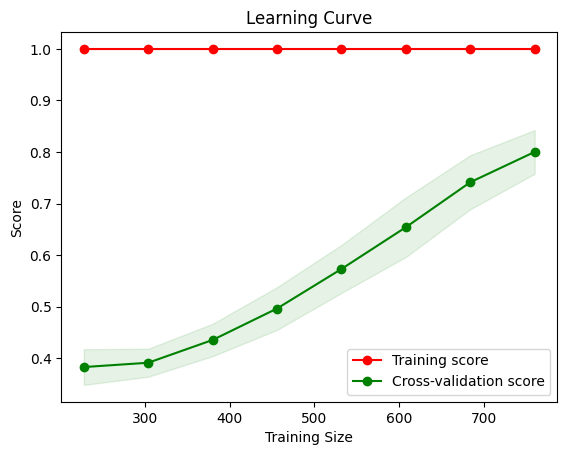

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X_manual_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

In [27]:
import pickle
with open('models/classifier.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [28]:
import joblib
rf = joblib.load('models/classifier.pkl')

In [119]:
from sklearn.model_selection import ParameterGrid
models = {
#     'Random Forest': RandomForestClassifier,
    'SVC': SVC,
    'Logistic Regression': LogisticRegression,
    'MLP Classifier': MLPClassifier
}

# Hyperparameters to tune for each model
params = {
#     'Random Forest': {
#         'n_estimators': [10, 50, 100],
#         'max_depth': [None, 10, 20],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'max_features': ['log2', 'sqrt']
#     },
    'SVC': {
        'C': [0.6, 1],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'MLP Classifier': {
        'hidden_layer_sizes': [(8, 16, 16), (8, 16), (16, 16)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
    }
}

for name, model_class in models.items():
    print(f"\nTuning hyperparameters for {name}")
    for param_set in ParameterGrid(params[name]):
        print(param_set)
        
#         print(param_set)
        param_set["random_state"]=9
        model = model_class(**param_set)
        
        model.fit(X_manual_train, y_train)
        y_pred = model.predict(X_manual_train)
        conf=report(model)
#         print(conf)

#         if conf[2,2]>=7 or conf[0, 0] >=9:
#             print("!!!!!!!!")
#             print(conf)
            
#             print(accuracy_score(y_pred, y_train))
            # Test

        print("---------------------------------")



Tuning hyperparameters for SVC
{'C': 0.6, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 1, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 3, 4, 4, 1, 0, 1, 2, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.8390404040404039
Recall: 0.8400000000000001
F1 Score: 0.8352183489025593
Accuracy: 0.84
Confusion Matrix:
[[ 8  0  1  1  0]
 [ 0 10  0  0  0]
 [ 2  0  7  1  0]
 [ 0  2  0  7  1]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.83      1.00      0.91        10
           2       0.88      0.70      0.78        10
           3       0.78      0.70      0.74        10
           4       0.91      1.00      0.95        10

    accuracy                           0.8

predictions: [2, 3, 2, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 1, 2, 3, 2, 2, 4, 2, 4, 2, 3, 4, 3, 3, 3, 3, 4, 3, 3, 0, 0, 3, 2, 2, 2, 1, 4, 4, 4, 3, 0, 3, 2, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7630701754385966
Recall: 0.68
F1 Score: 0.6818146987112503
Accuracy: 0.68
Confusion Matrix:
[[4 0 4 2 0]
 [0 6 0 4 0]
 [1 0 8 1 0]
 [0 0 0 9 1]
 [0 0 0 3 7]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       1.00      0.60      0.75        10
           2       0.67      0.80      0.73        10
           3       0.47      0.90      0.62        10
           4       0.88      0.70      0.78        10

    accuracy                           0.68        50
   macro avg       0.76      0.68      0.68        50
weighted avg       0.76      0.68      0.68        50

------------

predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 0, 4, 0, 3, 4, 3, 3, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 3, 0, 3, 0, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.796969696969697
Recall: 0.78
F1 Score: 0.7768113465481886
Accuracy: 0.78
Confusion Matrix:
[[8 0 1 1 0]
 [0 9 0 1 0]
 [4 0 5 1 0]
 [0 0 0 8 2]
 [0 0 0 1 9]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       1.00      0.90      0.95        10
           2       0.83      0.50      0.62        10
           3       0.67      0.80      0.73        10
           4       0.82      0.90      0.86        10

    accuracy                           0.78        50
   macro avg       0.80      0.78      0.78        50
weighted avg       0.80      0.78      0.78        50

-------------

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\computer-vision\codes\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\computer-vision\codes\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\computer-vision\codes\myenv\lib\site-packages\s

predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 1, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 3, 4, 4, 1, 0, 1, 2, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.8390404040404039
Recall: 0.8400000000000001
F1 Score: 0.8352183489025593
Accuracy: 0.84
Confusion Matrix:
[[ 8  0  1  1  0]
 [ 0 10  0  0  0]
 [ 2  0  7  1  0]
 [ 0  2  0  7  1]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.83      1.00      0.91        10
           2       0.88      0.70      0.78        10
           3       0.78      0.70      0.74        10
           4       0.91      1.00      0.95        10

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84     

predictions: [2, 3, 2, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 1, 2, 3, 2, 2, 4, 2, 4, 2, 3, 4, 3, 3, 3, 3, 4, 3, 3, 0, 0, 3, 2, 2, 2, 1, 4, 4, 4, 3, 0, 3, 2, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7630701754385966
Recall: 0.68
F1 Score: 0.6818146987112503
Accuracy: 0.68
Confusion Matrix:
[[4 0 4 2 0]
 [0 6 0 4 0]
 [1 0 8 1 0]
 [0 0 0 9 1]
 [0 0 0 3 7]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       1.00      0.60      0.75        10
           2       0.67      0.80      0.73        10
           3       0.47      0.90      0.62        10
           4       0.88      0.70      0.78        10

    accuracy                           0.68        50
   macro avg       0.76      0.68      0.68        50
weighted avg       0.76      0.68      0.68        50

------------

predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 0, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 3, 0, 3, 0, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.8121212121212121
Recall: 0.8
F1 Score: 0.794127363864206
Accuracy: 0.8
Confusion Matrix:
[[ 8  0  1  1  0]
 [ 0  9  0  1  0]
 [ 4  0  5  1  0]
 [ 0  0  0  8  2]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       1.00      0.90      0.95        10
           2       0.83      0.50      0.62        10
           3       0.73      0.80      0.76        10
           4       0.83      1.00      0.91        10

    accuracy                           0.80        50
   macro avg       0.81      0.80      0.79        50
weighted avg       0.81      0.80      0.79  

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


predictions: [2, 3, 2, 3, 1, 4, 3, 1, 4, 3, 1, 3, 0, 1, 3, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 3, 3, 4, 4, 3, 0, 1, 0, 1, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7834848484848485
Recall: 0.76
F1 Score: 0.755031746031746
Accuracy: 0.76
Confusion Matrix:
[[ 7  0  1  1  1]
 [ 0  7  0  3  0]
 [ 3  0  5  2  0]
 [ 0  1  0  9  0]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.88      0.70      0.78        10
           2       0.83      0.50      0.62        10
           3       0.60      0.90      0.72        10
           4       0.91      1.00      0.95        10

    accuracy                           0.76        50
   macro avg       0.78      0.76      0.76        50
weighted avg       0.78      0.76      0.76

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 4, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 2, 0, 0, 2, 1, 4, 4, 4, 3, 0, 1, 2, 0, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7644017094017095
Recall: 0.76
F1 Score: 0.756837020086448
Accuracy: 0.76
Confusion Matrix:
[[ 7  0  1  1  1]
 [ 1  7  1  1  0]
 [ 2  0  7  1  0]
 [ 0  1  0  7  2]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.88      0.70      0.78        10
           2       0.78      0.70      0.74        10
           3       0.70      0.70      0.70        10
           4       0.77      1.00      0.87        10

    accuracy                           0.76        50
   macro avg       0.76      0.76      0.76        50
weighted avg       0.76      0.76      0.76

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 4, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 1, 0, 3, 2, 2, 4, 2, 3, 4]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.8095238095238095
Recall: 0.8
F1 Score: 0.7982456140350875
Accuracy: 0.8
Confusion Matrix:
[[ 7  0  1  1  1]
 [ 0  9  1  0  0]
 [ 2  0  7  1  0]
 [ 0  0  0  7  3]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       1.00      0.90      0.95        10
           2       0.78      0.70      0.74        10
           3       0.78      0.70      0.74        10
           4       0.71      1.00      0.83        10

    accuracy                           0.80        50
   macro avg       0.81      0.80      0.80        50
weighted avg       0.81      0.80      0.80 

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 4, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 4, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 1, 0, 3, 2, 2, 4, 2, 3, 4]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7944444444444444
Recall: 0.78
F1 Score: 0.7775438596491228
Accuracy: 0.78
Confusion Matrix:
[[ 7  0  1  1  1]
 [ 0  9  1  0  0]
 [ 2  0  7  1  0]
 [ 0  0  0  6  4]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       1.00      0.90      0.95        10
           2       0.78      0.70      0.74        10
           3       0.75      0.60      0.67        10
           4       0.67      1.00      0.80        10

    accuracy                           0.78        50
   macro avg       0.79      0.78      0.78        50
weighted avg       0.79      0.78      0.7

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 4, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 4, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 1, 0, 3, 2, 2, 4, 2, 3, 4]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7944444444444444
Recall: 0.78
F1 Score: 0.7775438596491228
Accuracy: 0.78
Confusion Matrix:
[[ 7  0  1  1  1]
 [ 0  9  1  0  0]
 [ 2  0  7  1  0]
 [ 0  0  0  6  4]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       1.00      0.90      0.95        10
           2       0.78      0.70      0.74        10
           3       0.75      0.60      0.67        10
           4       0.67      1.00      0.80        10

    accuracy                           0.78        50
   macro avg       0.79      0.78      0.78        50
weighted avg       0.79      0.78      0.7

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 1, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 3, 4, 3, 0, 4, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 3, 1, 0, 1, 0, 2, 3, 2, 4, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.6798268398268399
Recall: 0.68
F1 Score: 0.6745301757066462
Accuracy: 0.68
Confusion Matrix:
[[8 0 1 0 1]
 [0 9 1 0 0]
 [3 1 5 1 0]
 [0 1 0 6 3]
 [1 0 0 3 6]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.82      0.90      0.86        10
           2       0.71      0.50      0.59        10
           3       0.60      0.60      0.60        10
           4       0.60      0.60      0.60        10

    accuracy                           0.68        50
   macro avg       0.68      0.68      0.67        50
weighted avg       0.68      0.68      0.67        50

------------

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 0, 4, 4, 4, 3, 1, 3, 0, 1, 2, 1, 4, 2, 4, 2, 4, 0, 3, 4, 3, 3, 4, 3, 4, 4, 0, 0, 0, 1, 0, 0, 2, 1, 3, 4, 4, 1, 0, 1, 2, 2, 4, 3, 2, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7451282051282051
Recall: 0.74
F1 Score: 0.7386270022883294
Accuracy: 0.74
Confusion Matrix:
[[7 0 2 0 1]
 [0 8 1 0 1]
 [2 0 6 2 0]
 [0 1 0 7 2]
 [0 0 0 1 9]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.89      0.80      0.84        10
           2       0.67      0.60      0.63        10
           3       0.70      0.70      0.70        10
           4       0.69      0.90      0.78        10

    accuracy                           0.74        50
   macro avg       0.75      0.74      0.74        50
weighted avg       0.75      0.74      0.74        50

------------

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 3, 4, 3, 0, 4, 0, 0, 0, 1, 0, 0, 2, 1, 3, 4, 4, 1, 0, 1, 0, 0, 4, 2, 4, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7755155955155955
Recall: 0.76
F1 Score: 0.7600562788044278
Accuracy: 0.76
Confusion Matrix:
[[8 0 1 0 1]
 [1 9 0 0 0]
 [3 0 6 1 0]
 [0 1 0 7 2]
 [1 0 0 1 8]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.90      0.90      0.90        10
           2       0.86      0.60      0.71        10
           3       0.78      0.70      0.74        10
           4       0.73      0.80      0.76        10

    accuracy                           0.76        50
   macro avg       0.78      0.76      0.76        50
weighted avg       0.78      0.76      0.76        50

------------

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 3, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 3, 3, 4, 4, 3, 0, 1, 0, 2, 4, 3, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7558441558441558
Recall: 0.74
F1 Score: 0.7350140056022407
Accuracy: 0.74
Confusion Matrix:
[[ 8  0  1  1  0]
 [ 0  6  1  3  0]
 [ 3  0  5  2  0]
 [ 0  1  0  8  1]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.86      0.60      0.71        10
           2       0.71      0.50      0.59        10
           3       0.57      0.80      0.67        10
           4       0.91      1.00      0.95        10

    accuracy                           0.74        50
   macro avg       0.76      0.74      0.74        50
weighted avg       0.76      0.74      0.7

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 3, 1, 4, 4, 1, 4, 3, 3, 3, 0, 1, 2, 1, 4, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 3, 0, 4, 4, 1, 0, 3, 0, 2, 4, 3, 2, 4]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7045238095238096
Recall: 0.6799999999999999
F1 Score: 0.6750505050505049
Accuracy: 0.68
Confusion Matrix:
[[ 6  0  2  0  2]
 [ 0  6  1  3  0]
 [ 3  0  5  2  0]
 [ 1  0  0  7  2]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       1.00      0.60      0.75        10
           2       0.62      0.50      0.56        10
           3       0.58      0.70      0.64        10
           4       0.71      1.00      0.83        10

    accuracy                           0.68        50
   macro avg       0.70      0.68      0.68        50
weighted avg       0.70     

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 4, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 3, 4, 3, 4, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 4, 4, 1, 0, 3, 0, 0, 4, 2, 2, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7561050061050061
Recall: 0.74
F1 Score: 0.7398646581578335
Accuracy: 0.74
Confusion Matrix:
[[7 0 2 0 1]
 [1 9 0 0 0]
 [4 0 5 1 0]
 [1 0 0 7 2]
 [0 0 0 1 9]]
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       1.00      0.90      0.95        10
           2       0.71      0.50      0.59        10
           3       0.78      0.70      0.74        10
           4       0.75      0.90      0.82        10

    accuracy                           0.74        50
   macro avg       0.76      0.74      0.74        50
weighted avg       0.76      0.74      0.74        50

------------

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 2, 2, 1, 1, 4, 4, 1, 4, 3, 3, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 4, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 1, 0, 3, 0, 2, 4, 1, 2, 4]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7050793650793651
Recall: 0.7
F1 Score: 0.6913312693498451
Accuracy: 0.7
Confusion Matrix:
[[ 7  0  2  0  1]
 [ 0  8  1  1  0]
 [ 3  1  5  1  0]
 [ 0  0  1  5  4]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.89      0.80      0.84        10
           2       0.56      0.50      0.53        10
           3       0.71      0.50      0.59        10
           4       0.67      1.00      0.80        10

    accuracy                           0.70        50
   macro avg       0.71      0.70      0.69        50
weighted avg       0.71      0.70      0.69 

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 4, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 4, 4, 3, 4, 4, 3, 4, 4, 0, 0, 0, 1, 0, 0, 0, 1, 3, 4, 4, 1, 0, 3, 0, 1, 4, 1, 2, 1]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7428571428571429
Recall: 0.74
F1 Score: 0.718939393939394
Accuracy: 0.74
Confusion Matrix:
[[ 8  0  2  0  0]
 [ 0 10  0  0  0]
 [ 4  1  4  1  0]
 [ 0  1  0  5  4]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.83      1.00      0.91        10
           2       0.67      0.40      0.50        10
           3       0.83      0.50      0.62        10
           4       0.71      1.00      0.83        10

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.72        50
weighted avg       0.74      0.74      0.72

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 1, 1, 0, 4, 1, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 1, 4, 4, 4, 1, 0, 3, 0, 2, 4, 2, 2, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.8232323232323232
Recall: 0.8200000000000001
F1 Score: 0.8184096605149238
Accuracy: 0.82
Confusion Matrix:
[[ 8  0  2  0  0]
 [ 0  9  1  0  0]
 [ 3  0  6  1  0]
 [ 0  0  0  8  2]
 [ 0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       1.00      0.90      0.95        10
           2       0.67      0.60      0.63        10
           3       0.89      0.80      0.84        10
           4       0.83      1.00      0.91        10

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82     

D:\computer-vision\codes\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


predictions: [2, 3, 2, 3, 1, 4, 4, 4, 4, 3, 1, 3, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 4, 4, 3, 3, 4, 3, 4, 3, 0, 0, 0, 1, 0, 0, 2, 3, 4, 4, 4, 3, 0, 3, 0, 2, 4, 2, 3, 3]
true_labels: [0, 3, 2, 1, 1, 0, 3, 1, 4, 3, 1, 2, 0, 1, 2, 1, 0, 2, 4, 2, 4, 0, 3, 4, 3, 4, 4, 3, 4, 3, 0, 0, 0, 1, 2, 0, 2, 1, 3, 4, 4, 1, 2, 3, 2, 1, 4, 2, 0, 3]
Precision: 0.7262637362637363
Recall: 0.6799999999999999
F1 Score: 0.6784057971014492
Accuracy: 0.68
Confusion Matrix:
[[7 0 1 1 1]
 [0 5 1 3 1]
 [3 0 6 1 0]
 [0 0 0 7 3]
 [0 0 0 1 9]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       1.00      0.50      0.67        10
           2       0.75      0.60      0.67        10
           3       0.54      0.70      0.61        10
           4       0.64      0.90      0.75        10

    accuracy                           0.68        50
   macro avg       0.73      0.68      0.68        50
weighted avg       0.73      0.68      0.68        50

## only with manual features

In [26]:
features = pd.read_csv("./results/Cardiac_parameters.csv")
X = features.drop(columns=["Category", "Id"])
y = features["Category"]

feature_names = X.columns
X_train = X[:100]
y_train = y[:100]
X_test = X[100:150]
y_test = y[100:150]

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train) # M=1 and B=0
y_test = labelencoder.transform(y_test) # M=1 and B=0

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


models= [
        ('mlp2', MLPClassifier(activation="relu", random_state=9, solver="sgd", hidden_layer_sizes=[16, 16], max_iter=300)), 
        ('rf',RandomForestClassifier(random_state=9, **{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10})), 
          ]
rf = VotingClassifier(estimators=models, voting='hard')
rf.fit(X_train, y_train)
 
y_pred = rf.predict(X_test)
print("y_pred",y_pred)
print("y_test", y_test)
 
print(classification_report(y_test,y_pred))
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test,y_pred))
y_pred = rf.predict(X_train)
print(accuracy_score(y_pred, y_train))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# rf = RandomForestClassifier(n_estimators=500)
# rf = SVC(kernel="rbf")
rf= MLPClassifier(max_iter=2000,activation="tanh", random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("y_pred",y_pred)
print("y_test", y_test)
print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))
print(accuracy_score(y_pred, y_test))
y_pred = rf.predict(X_train)
print(confusion_matrix(y_train,y_pred))
print(accuracy_score(y_pred, y_train))